In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from itertools import combinations

In [2]:
sns.set_style("white")
sns.set_context("talk", font_scale=0.9)

## Data loading and inspection

In [3]:
df_path = "/home/space/diverse_priors/results/aggregated/r_coeff_dist/agg_corr_coeffs_all_ds.csv"

In [4]:
df = pd.read_csv(df_path)

anchor_name_mapping = {
    'OpenCLIP_RN50_openai': 'OpenCLIP RN50',
    'OpenCLIP_ViT-L-14_openai': 'OpenCLIP ViT-L',
    'resnet50': 'ResNet-50',
    'vit_large_patch16_224': 'ViT-L',
    'simclr-rn50': 'SimCLR RN50',
    'dino-vit-base-p16': 'DINO ViT-B',
    'dinov2-vit-large-p14': 'DINOv2 ViT-L',
    'mae-vit-large-p16': 'MAE ViT-L'
}

df["Anchor Model"] = df["Anchor Model"].replace(anchor_name_mapping)

print(len(df),"rows")
df.head()

122400 rows


,Similarity metric,Anchor Model,DS 1,DS 2,r coeff,Comparison values,Comparison category,Comparison category (orig. name)
0,CKA RBF 0.4,OpenCLIP RN50,imagenet-subset-10k,wds_fer2013,0.464330,All,Objective,objective
1,CKA RBF 0.4,OpenCLIP RN50,imagenet-subset-10k,wds_voc2007,0.656493,All,Objective,objective
2,CKA RBF 0.4,OpenCLIP RN50,imagenet-subset-10k,wds_cars,0.574971,All,Objective,objective
3,CKA RBF 0.4,OpenCLIP RN50,imagenet-subset-10k,wds_fgvc_aircraft,0.458443,All,Objective,objective
4,CKA RBF 0.4,OpenCLIP RN50,imagenet-subset-10k,wds_stl10,0.918862,All,Objective,objective


In [5]:
def get_wasserstein_df(df):
    sim_metrics = df['Similarity metric'].unique()
    metric_combs = list(combinations(sim_metrics, 2))

    rows = []

    for key, group_data in df.groupby(['Anchor Model', 'Comparison category', 'Comparison values']):
        for met1, met2 in metric_combs:
            r_vals_met1 = group_data[group_data['Similarity metric'] == met1]['r coeff']
            r_vals_met2 = group_data[group_data['Similarity metric'] == met2]['r coeff']
            ws_dist = wasserstein_distance(r_vals_met1, r_vals_met2)
            rows.append({
                'Anchor Model':key[0], 
                'Comparison category':key[1], 
                'Comparison values':key[2],
                'Metric1': met1,
                'Metric2':met2,
                'Wasserstein': ws_dist
            })
    ws_df = pd.DataFrame(rows)
    return ws_df

def color_map_idx(anchor):
    if anchor.startswith("O"): 
        idx = 0
    elif anchor[0] in ["R","V"]: 
        idx = 2
    elif anchor[0] in ["D", "S","M"]: 
        idx = 1
    else: 
        idx = 3
    return idx

def plot_metric_comparison_cat_table(distance_df, title_postfix=None, display=True, filename=None, sort_func=None):
    anchors = distance_df['Anchor Model'].unique()
    metrics = distance_df[['Metric1', 'Metric2']].values.ravel()
    metrics = sorted(set(metrics))  # Get unique metrics and sort them

    combined_matrix = pd.DataFrame()

    for anchor in anchors:
        filtered_df = distance_df[distance_df['Anchor Model'] == anchor]
        filtered_df = filtered_df[
            filtered_df.apply(
                lambda row: metrics.index(row['Metric1']) < metrics.index(row['Metric2']),
                axis=1
            )
        ]
        
        avg_distance_matrix = (
            filtered_df.groupby(['Metric1', 'Metric2'])['Wasserstein']
            .mean().unstack()
        )
        
        avg_distance_series = avg_distance_matrix.stack()
        avg_distance_series.name = anchor
                
        combined_matrix = pd.concat([combined_matrix, avg_distance_series], axis=1)

    combined_matrix = combined_matrix.T

    if sort_func:
        sorted_anchors = sorted(anchors, key=sort_func)
        combined_matrix = combined_matrix.loc[sorted_anchors]
    
    vmax = combined_matrix.max().max()
    
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(
        combined_matrix,
        cmap='Greys',
        annot=True,
        fmt=".2f",
        vmin=0,
        vmax=vmax,
    )
    
    x_labels = [item.get_text().replace('-', '\n') for item in ax.get_xticklabels()]
    ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
    
    # Coloring the labels
    tab10 = plt.get_cmap('tab10')
    label_colors = {label.get_text(): tab10(color_map_idx(label.get_text())) for label in ax.get_yticklabels()}
    for tick_label in ax.get_yticklabels():
        label_text = tick_label.get_text()
        tick_label.set_color(label_colors.get(label_text, 'black'))  # Default to black if label not found
    
    title = 'Average Pairwise Wasserstein Distance'
    if title_postfix is not None:
        title += " " + title_postfix
    plt.title(title, pad=15)
    plt.xlabel(None)
    plt.ylabel('Anchor Model')
    
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)
    if display:
        plt.show()
    else:
        plt.close()
        
def custom_sort(anchor):
    if anchor.startswith("O"): idx = 0
    elif anchor.startswith("D"): idx = 1
    elif anchor[0] in ["D","S"]: idx = 2
    else: idx = 3
    return idx

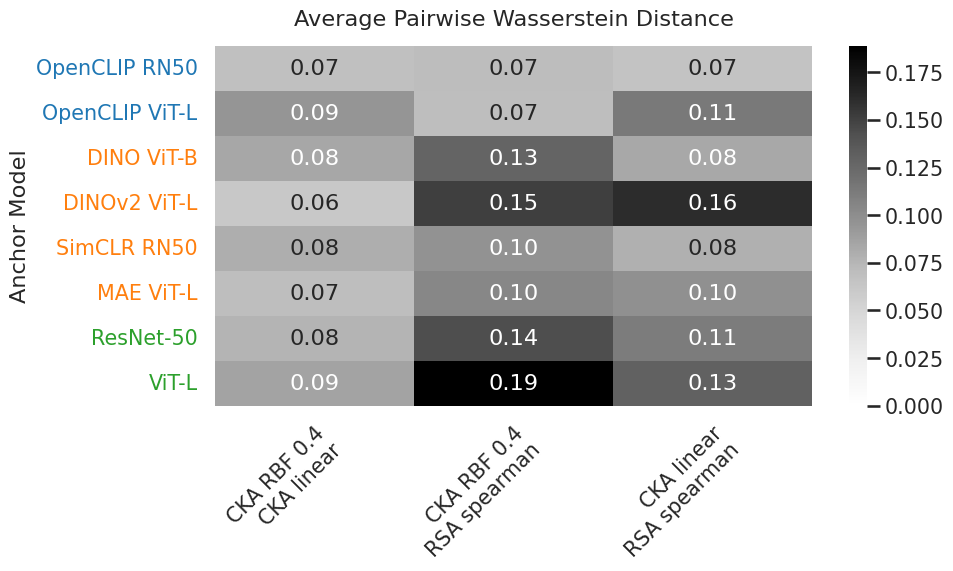

In [6]:
# When averaging over Comparison values, we ignore All, to avoid double-counting
df_ws = get_wasserstein_df(df[df["Comparison category"]!="All"])
plot_metric_comparison_cat_table(df_ws, sort_func=custom_sort, filename="avg_wasserstein.pdf")

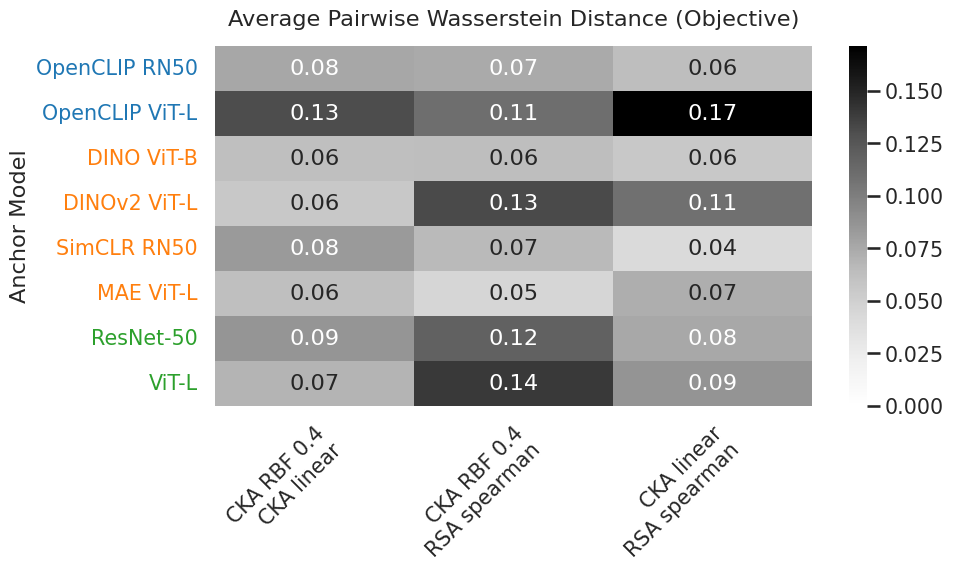

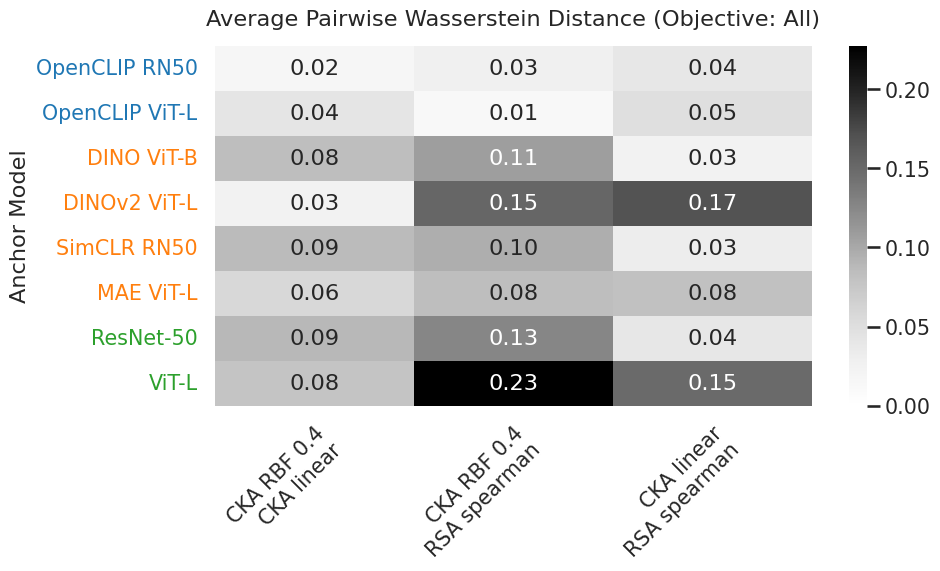

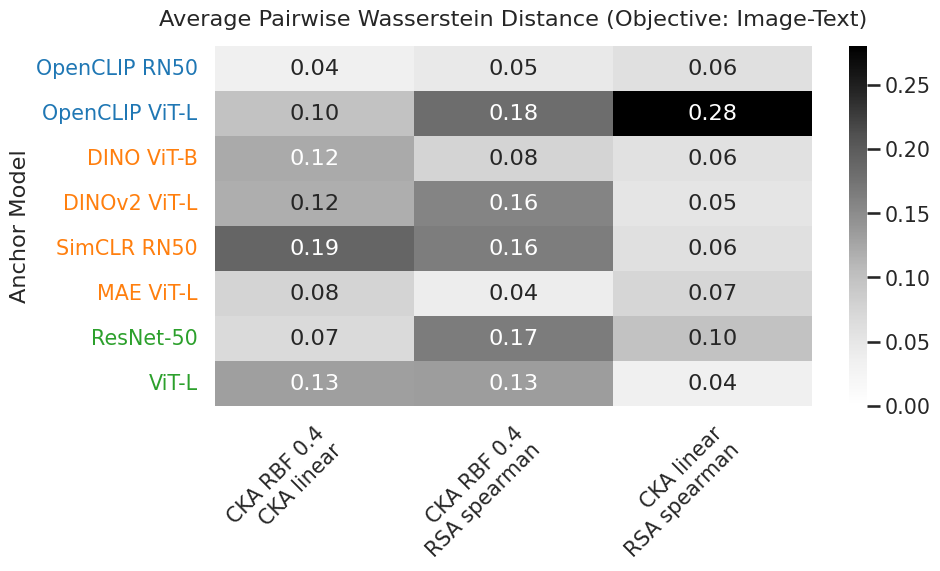

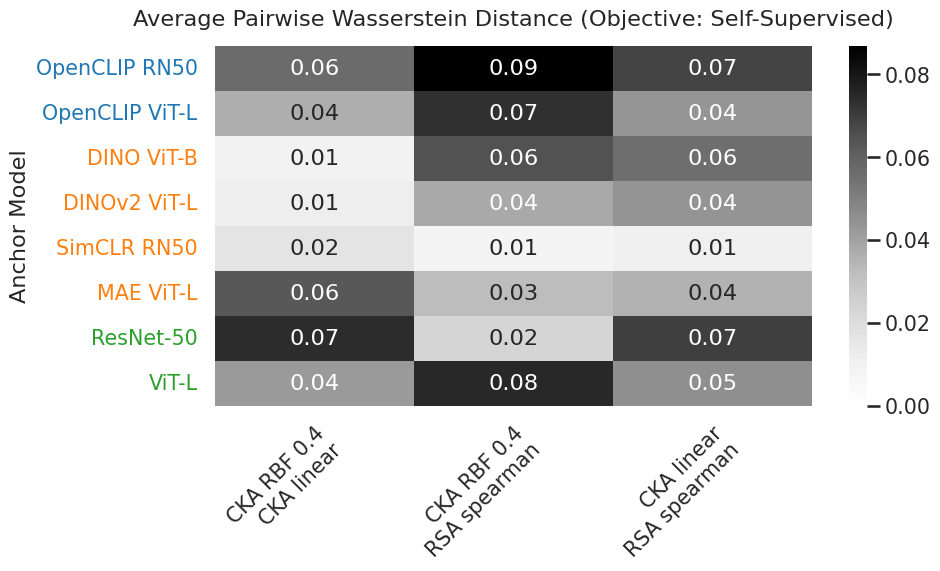

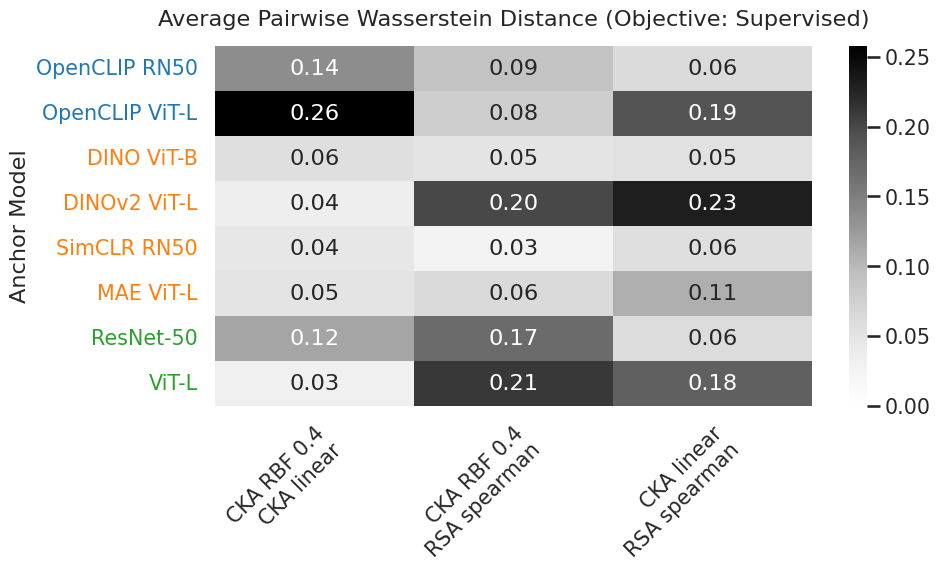

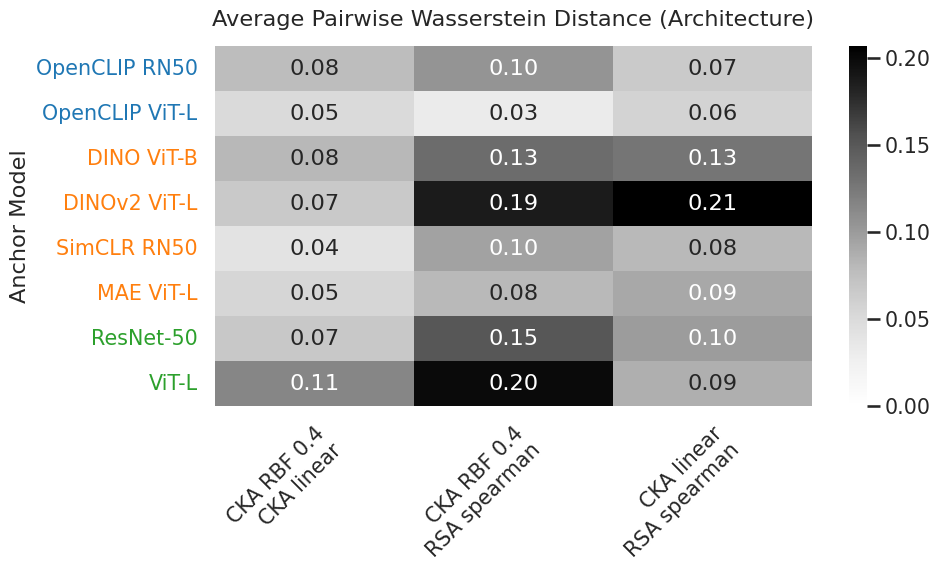

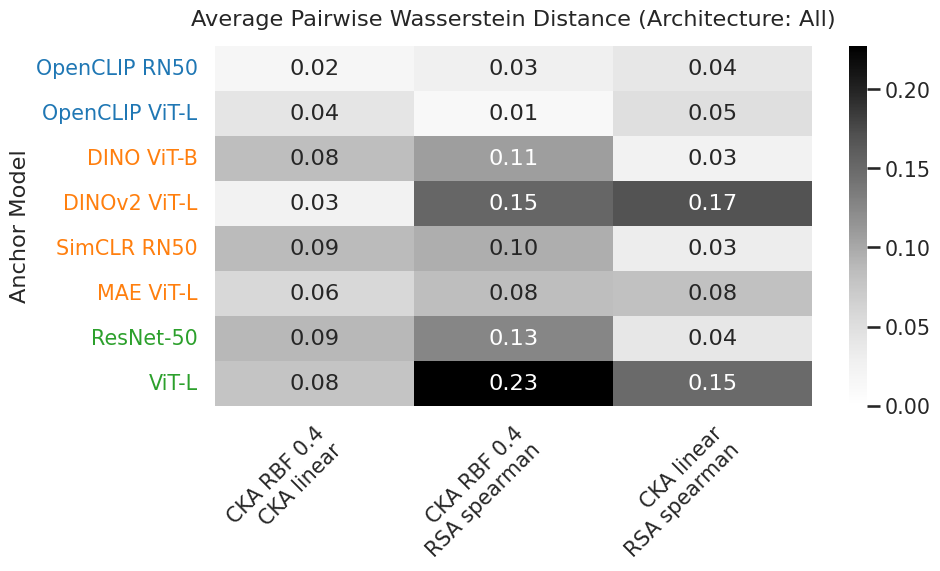

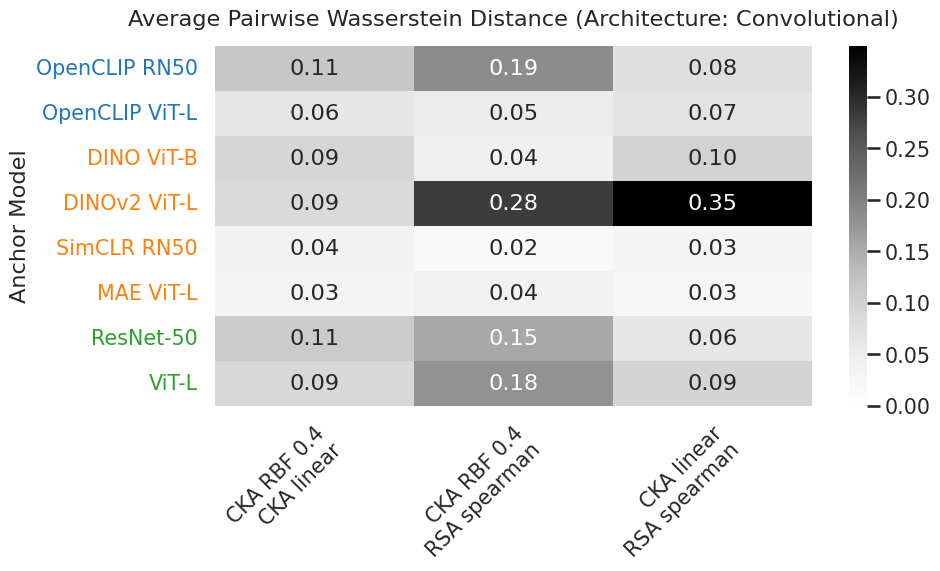

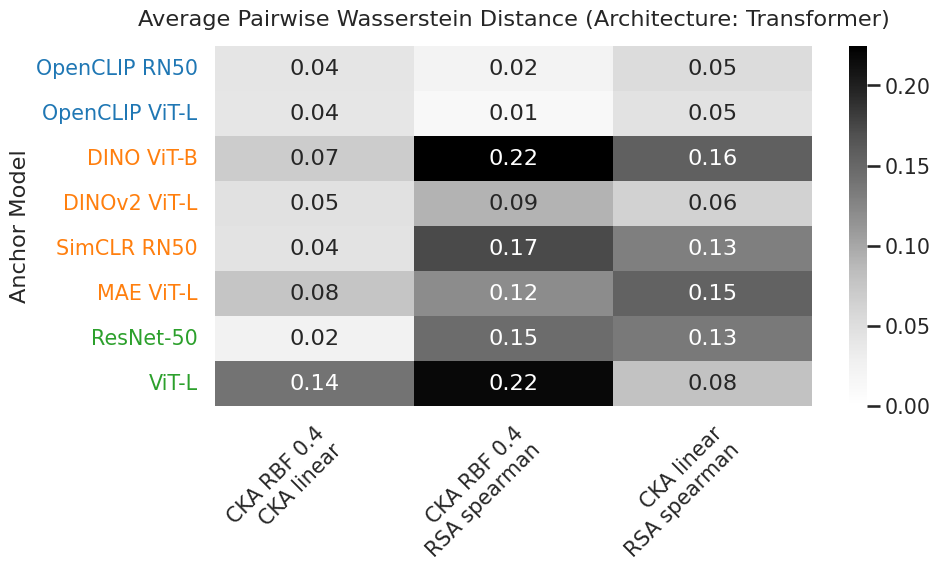

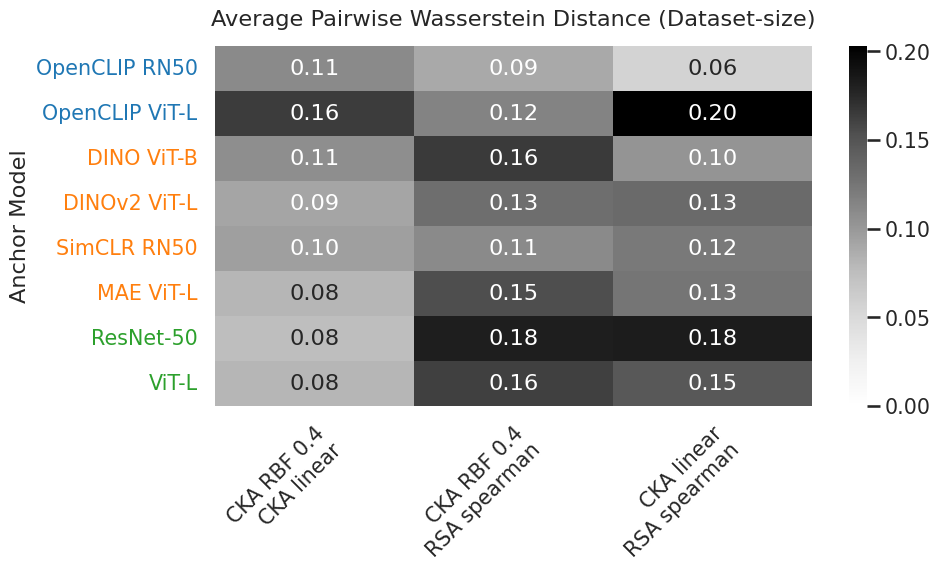

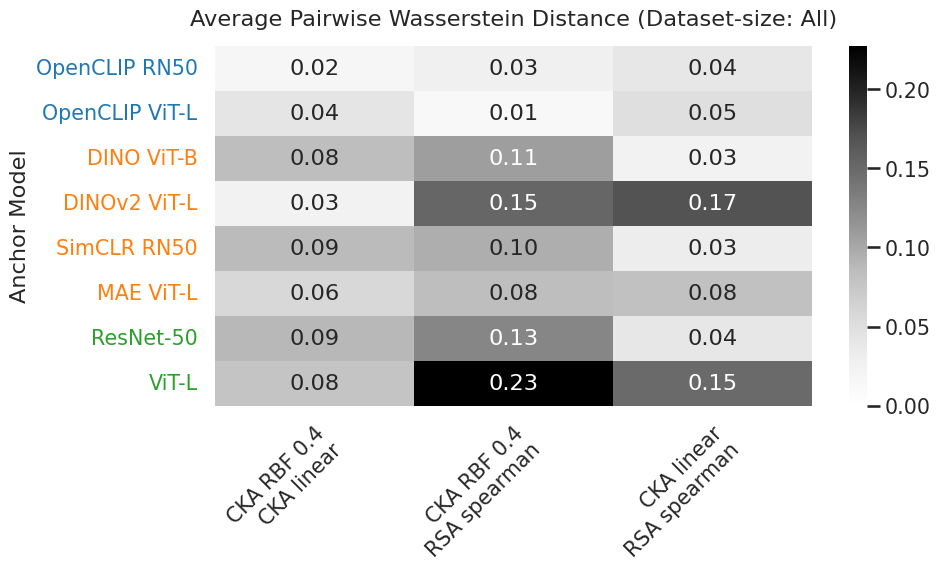

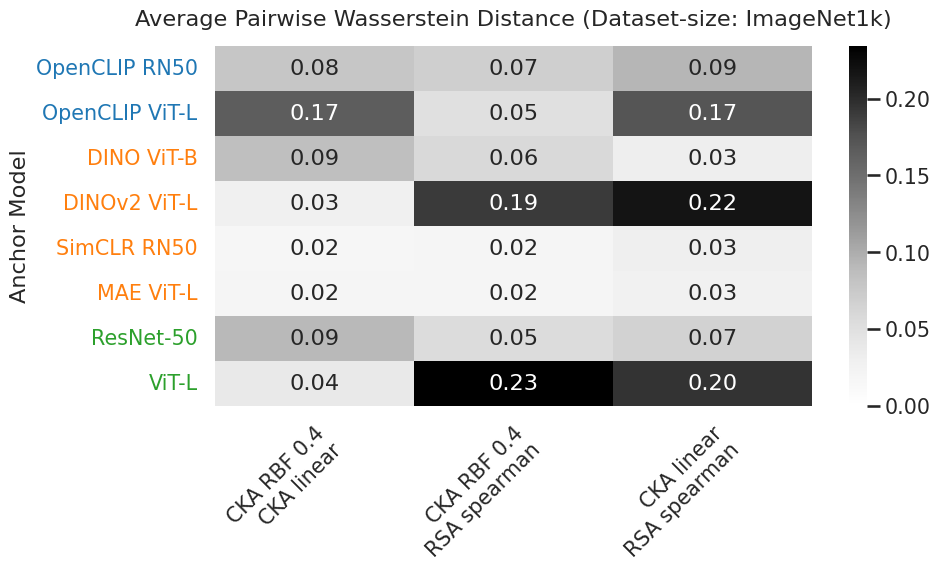

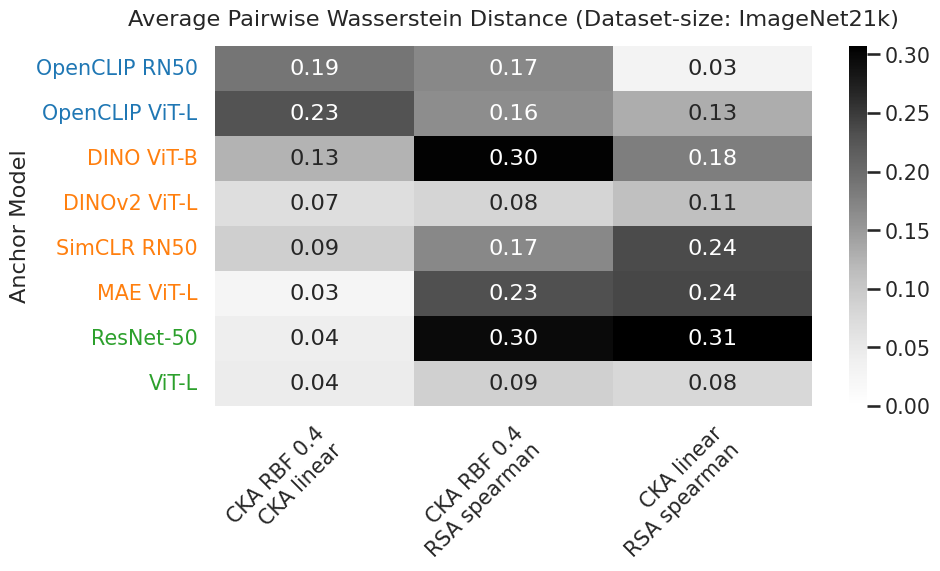

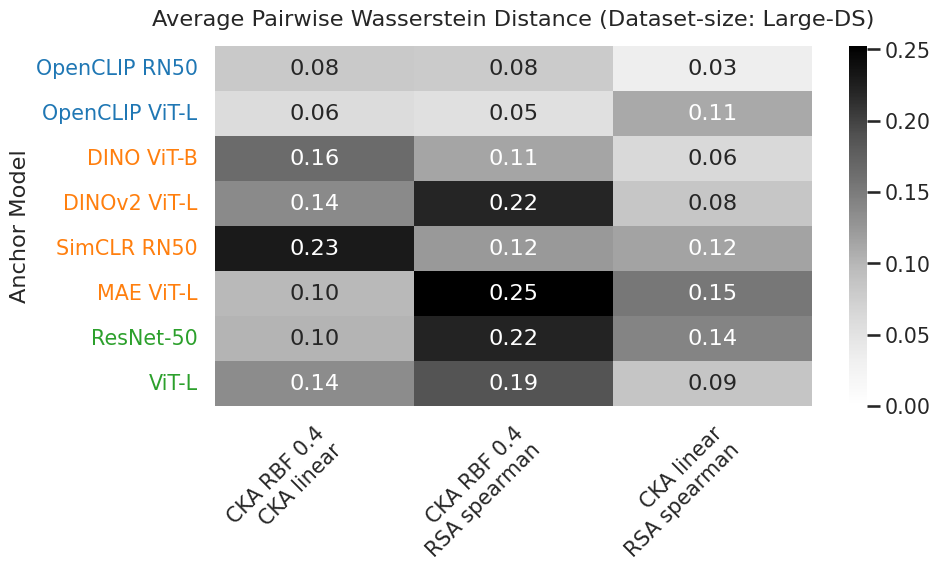

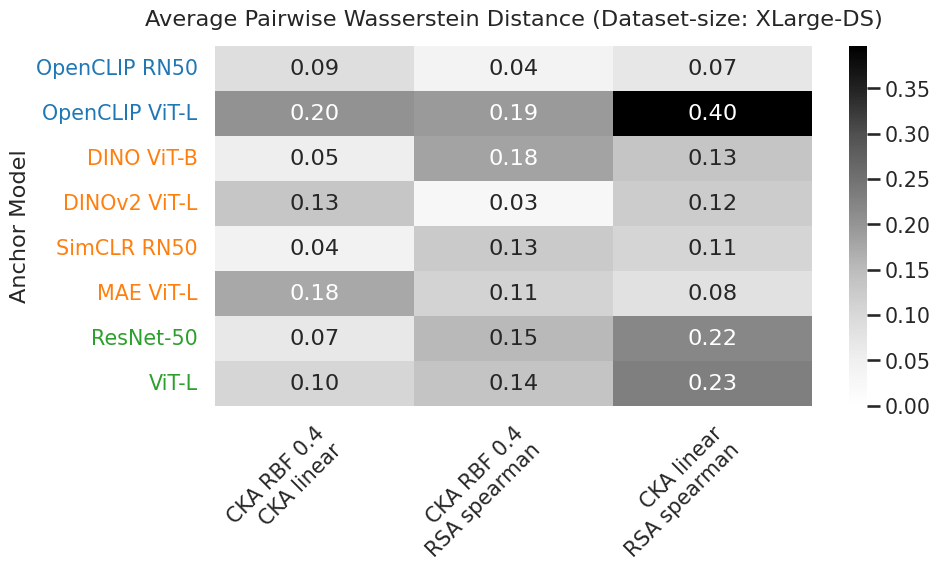

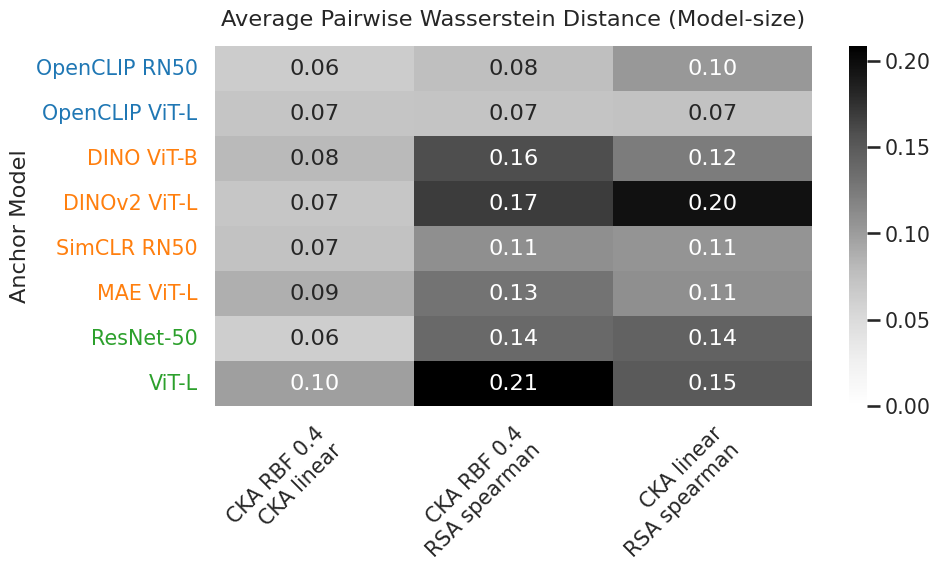

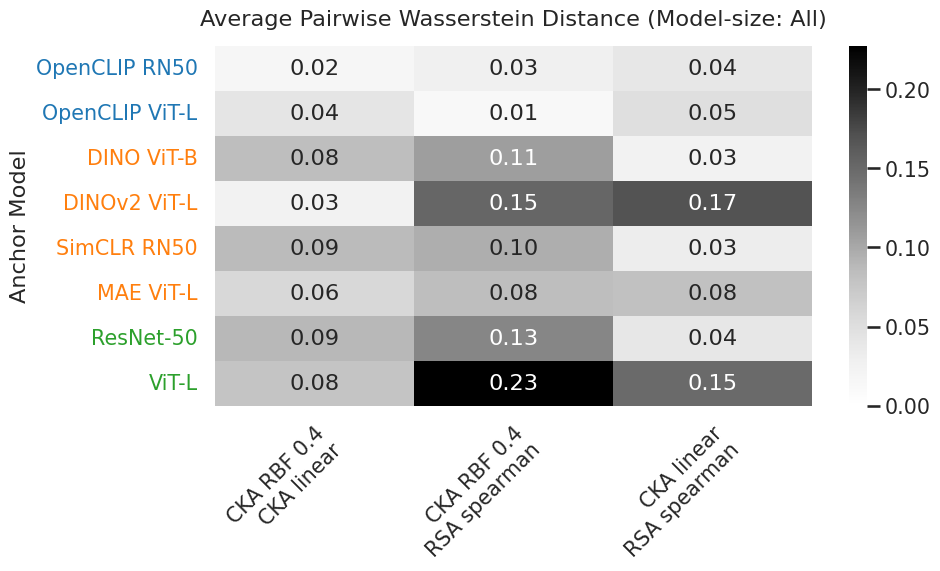

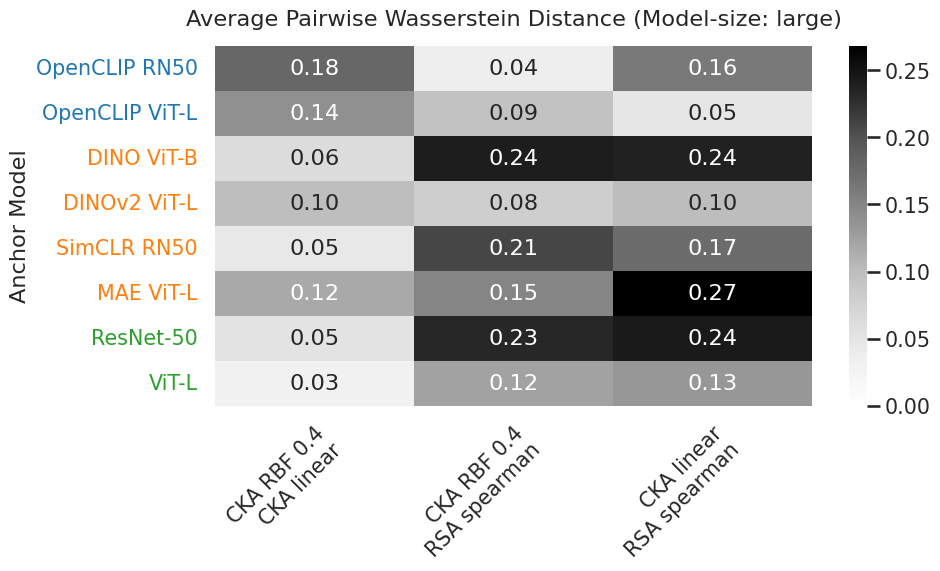

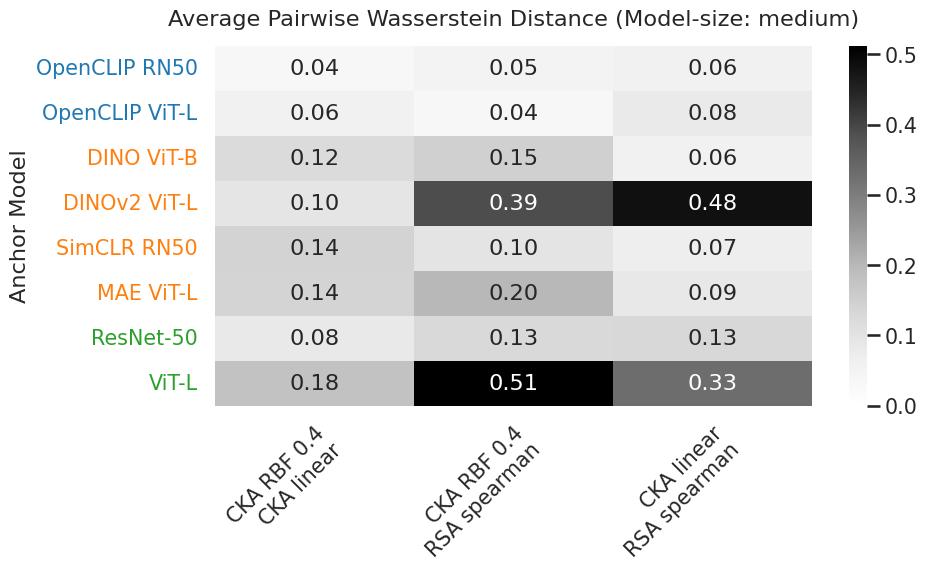

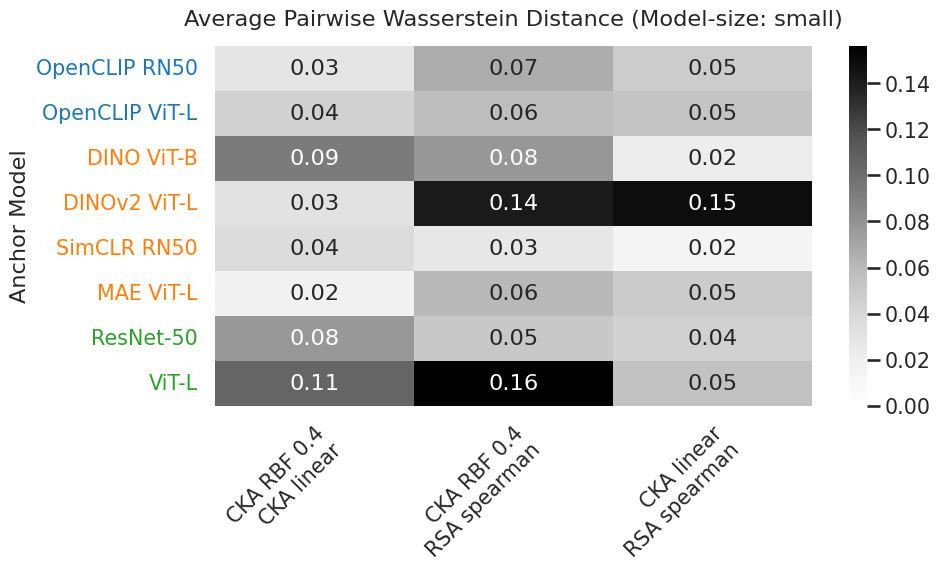

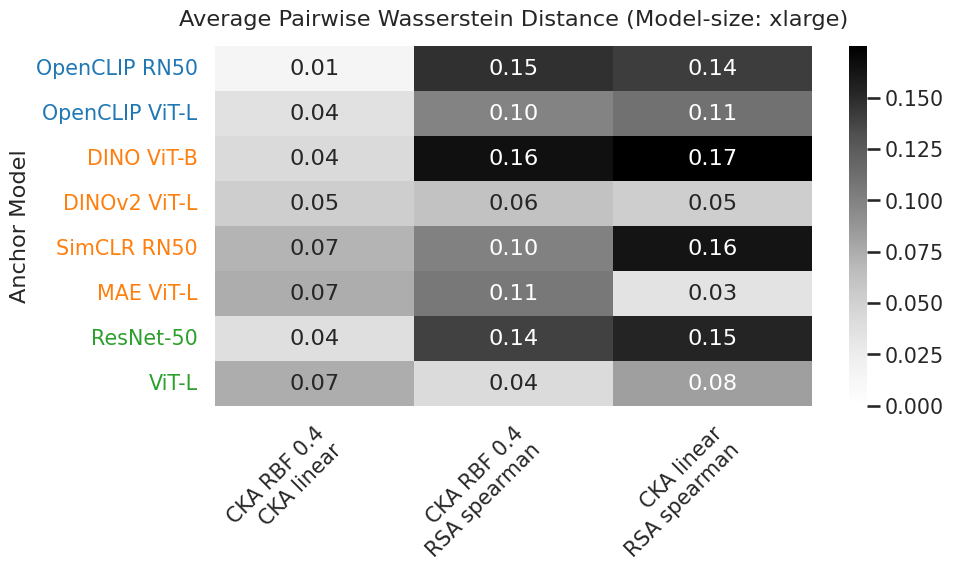

In [7]:
for cat in df["Comparison category"].unique():
    df_cat = df[df["Comparison category"] == cat]
    
    # When averaging over Comparison values, we ignore All, to avoid double-counting
    df_cat_no_all = df_cat[df_cat["Comparison values"] != "All"]
    df_ws = get_wasserstein_df(df_cat_no_all)
    plot_metric_comparison_cat_table(df_ws, sort_func=custom_sort, title_postfix=f"({cat.replace(' ','-')})", filename=f"avg_wasserstein_{cat.replace(' ','-')}.pdf")
    
    for val in df_cat["Comparison values"].unique():
        df_cat_val = df_cat[df_cat["Comparison values"] == val]
        df_ws = get_wasserstein_df(df_cat_val)
        plot_metric_comparison_cat_table(df_ws, sort_func=custom_sort, title_postfix=f"({cat.replace(' ','-')}: {val.replace(' ','-')})", filename=f"avg_wasserstein_{cat.replace(' ','-')}_{val.replace(' ','-')}.pdf")